# Модель для предсказания цен на недвижимость
# 


## Исходные данные по объектам недвижимости - файл train.csv

Описание данных датасетa:

Id - идентификационный номер квартиры

DistrictId - идентификационный номер района

Rooms - количество комнат

Square - площадь

LifeSquare - жилая площадь

KitchenSquare - площадь кухни

Floor - этаж

HouseFloor - количество этажей в доме

HouseYear - год постройки дома

Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности

Social_1, Social_2, Social_3 - социальные показатели местности

Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья

Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров

Price - цена квартиры

Подключение библиотек и скриптов

In [38]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

In [39]:
# Пути к директориям и файлам, загрузка данных
DATA_TRAIN_PATH = r'C:\Users\user\Documents\Realty_Data\train.csv'
DATA_TEST_PATH = (r'C:\Users\user\Documents\Realty_Data\test.csv')
DATA_PREDICTION_PATH = (r'C:\Users\user\Documents\Realty_Data\SShulgin_prediction.csv')
data_train = pd.read_csv(DATA_TRAIN_PATH, sep = ',')
data_test = pd.read_csv(DATA_TRAIN_PATH, sep = ',')


In [40]:
# Проверка загрузкой данных
data_train.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524


In [41]:
data_test.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524


Анализ представленных в датасетах данных

In [42]:
# На всякий случай делаем копию датасета, чтобы не испортить случайно "эталонные" данные:
X = data_train.copy()

In [43]:
# Идентификатор объекта Id не несет никакой информации для целей машинного обучения. Поэтому пока его удаляем.
X = X.drop(['Id'], axis = 1)
X.head(3)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524


In [44]:
# Анализируем датасет на предмет корректности типов данных и отсутсвующих данных
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  object 
 18  Price  

In [45]:
# С помощью .describe получим первичное понимание того, что из себя представляют данные
np.set_printoptions(suppress = True)
X.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [46]:
# Преобразуем типы данных, исходя из их фактических значений
# Для этого вводим подпрограмму
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [47]:
X = reduce_mem_usage(X)

Memory usage of dataframe is 1.45 MB
Memory usage after optimization is: 0.47 MB
Decreased by 67.7%


In [48]:
# Посмотрим на новые типы данных
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   DistrictId     10000 non-null  int16   
 1   Rooms          10000 non-null  float32 
 2   Square         10000 non-null  float32 
 3   LifeSquare     7887 non-null   float32 
 4   KitchenSquare  10000 non-null  float32 
 5   Floor          10000 non-null  int8    
 6   HouseFloor     10000 non-null  float32 
 7   HouseYear      10000 non-null  int32   
 8   Ecology_1      10000 non-null  float32 
 9   Ecology_2      10000 non-null  category
 10  Ecology_3      10000 non-null  category
 11  Social_1       10000 non-null  int8    
 12  Social_2       10000 non-null  int16   
 13  Social_3       10000 non-null  int16   
 14  Healthcare_1   5202 non-null   float32 
 15  Helthcare_2    10000 non-null  int8    
 16  Shops_1        10000 non-null  int8    
 17  Shops_2        10000 non-null  c

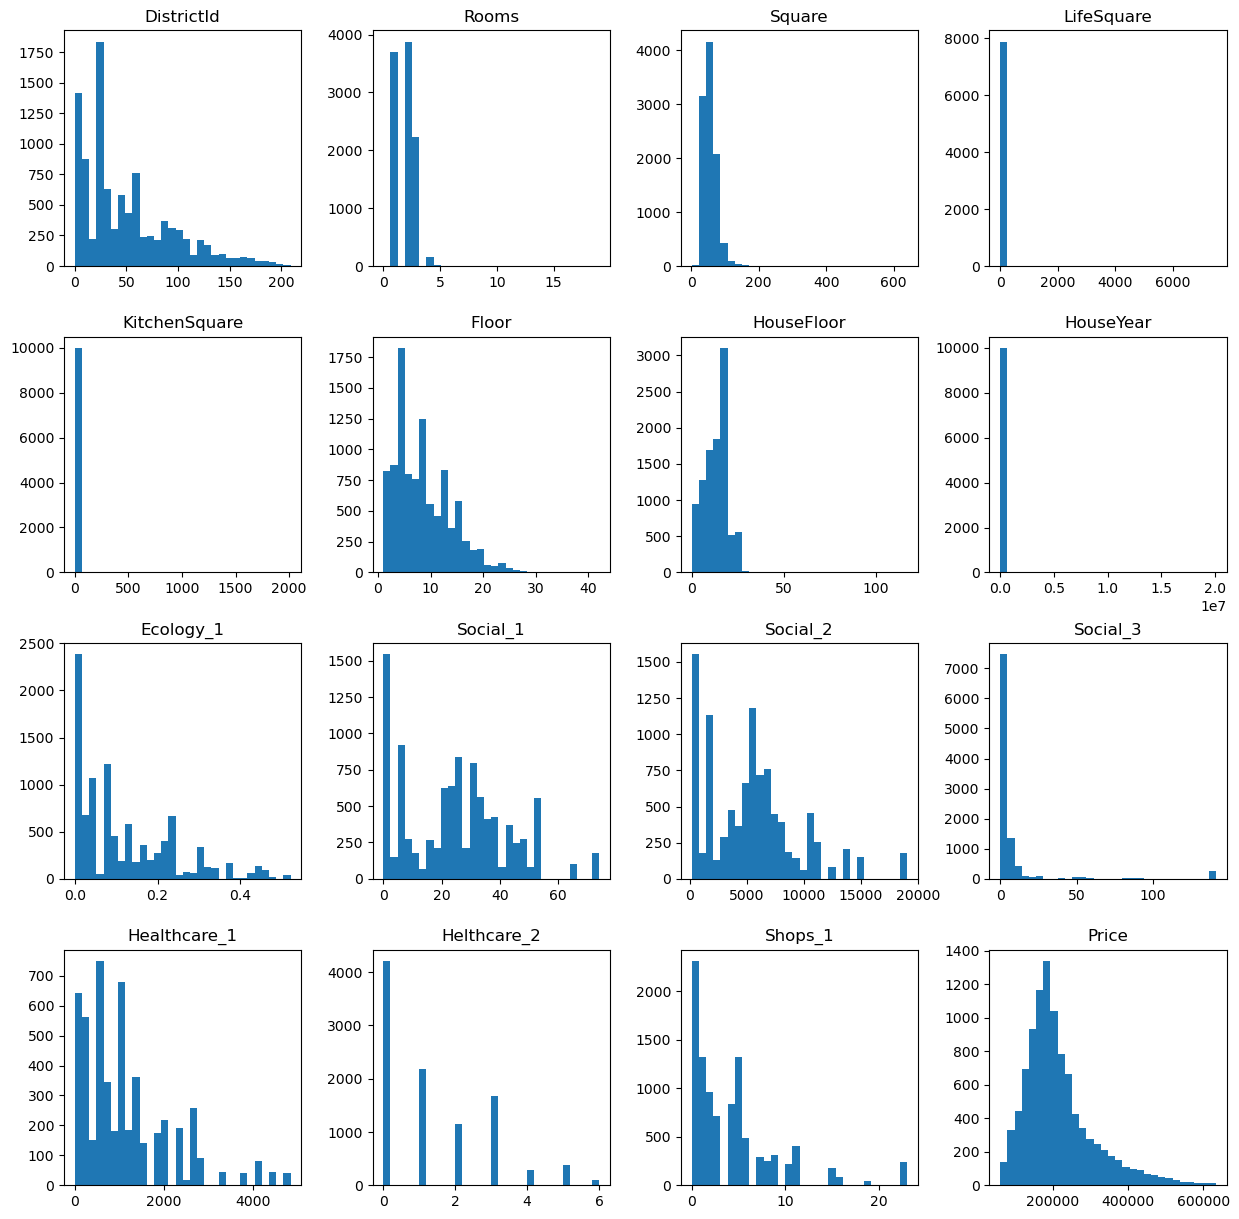

In [49]:
# Посмотрим бегло на распределение числовых признаков
X_num_features = X.select_dtypes(exclude=['category'])
X_num_features.hist(figsize=(15,15), bins=30, grid=False)
plt.show()

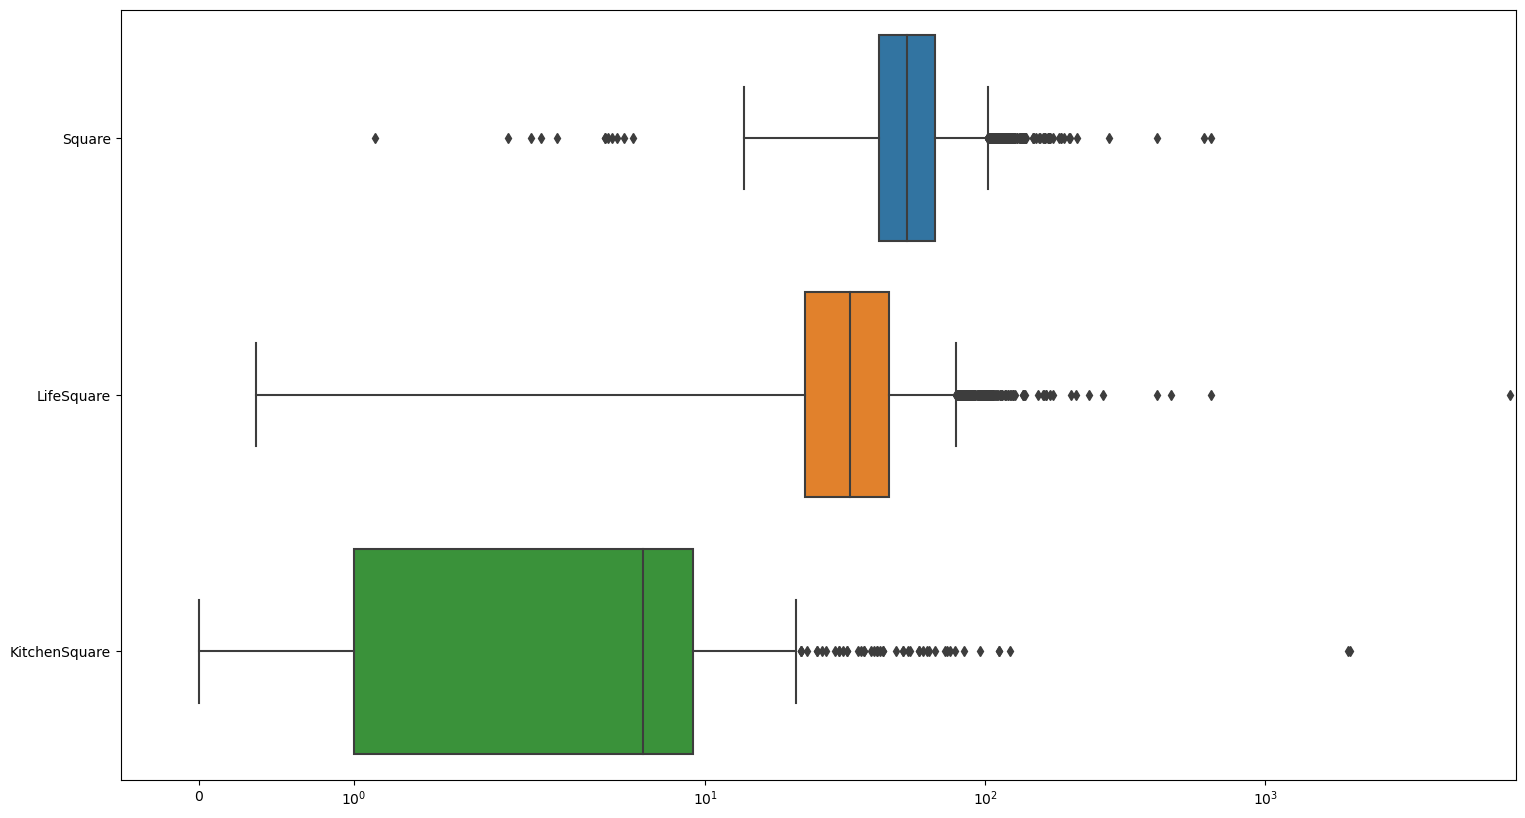

In [50]:
# Уточним для наглядности выбросы по площадям объектов (общая, жилая, кухня), используя логарифмическую шкалу
plt.figure(figsize=(18, 10))
sns.boxplot(data=X[['Square', 'LifeSquare', 'KitchenSquare']], orient='h')
plt.xscale('symlog')
plt.xlim(left=-0.5)
plt.show()

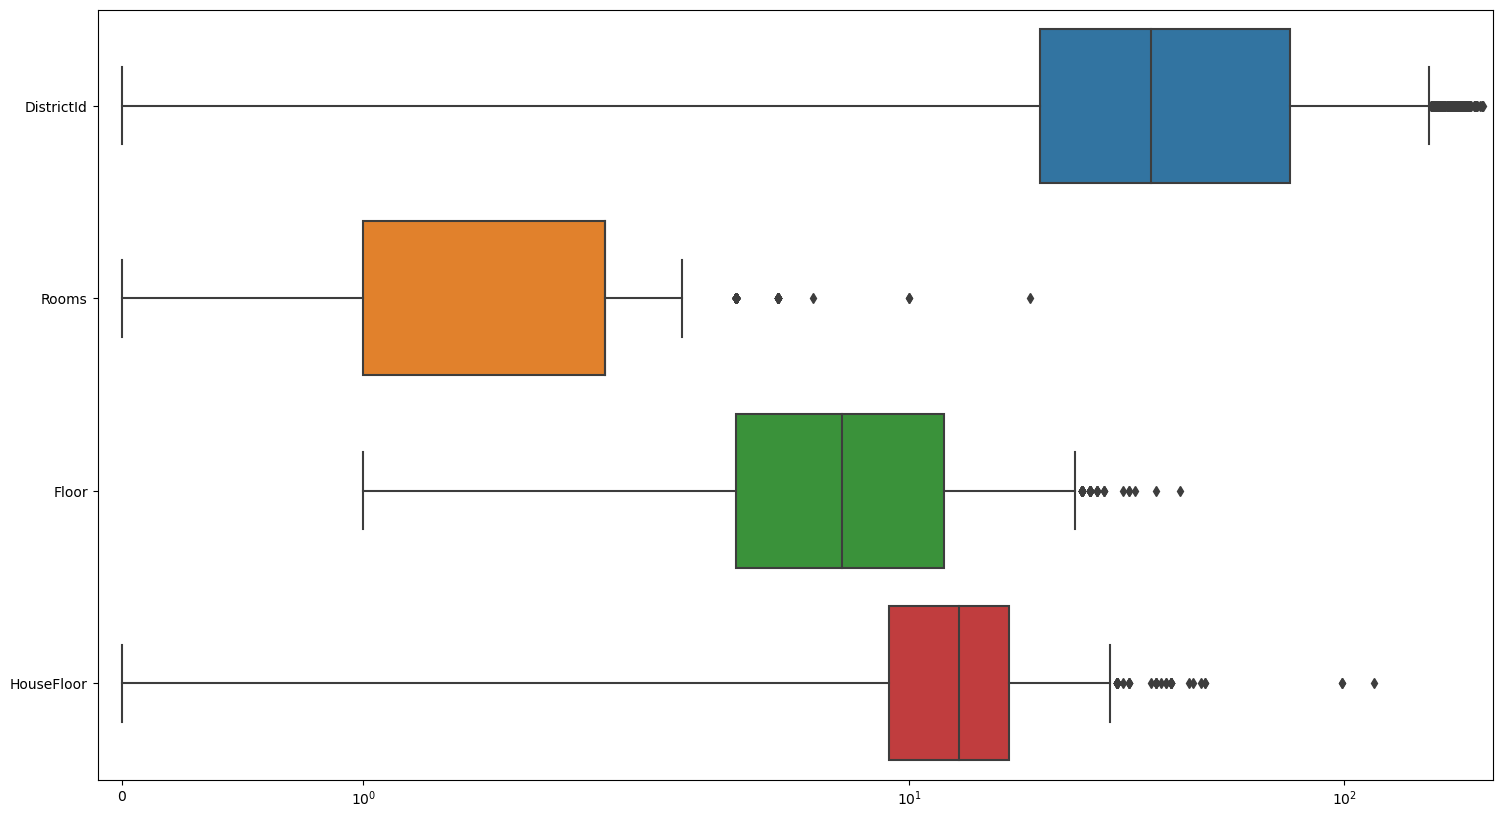

In [51]:
# Уточним для наглядности выбросы по целочисленным значениям
plt.figure(figsize=(18, 10))
sns.boxplot(data=X[['DistrictId', 'Rooms', 'Floor', 'HouseFloor', ]], orient='h')
plt.xscale('symlog')
plt.xlim(left=-0.1)
plt.show()

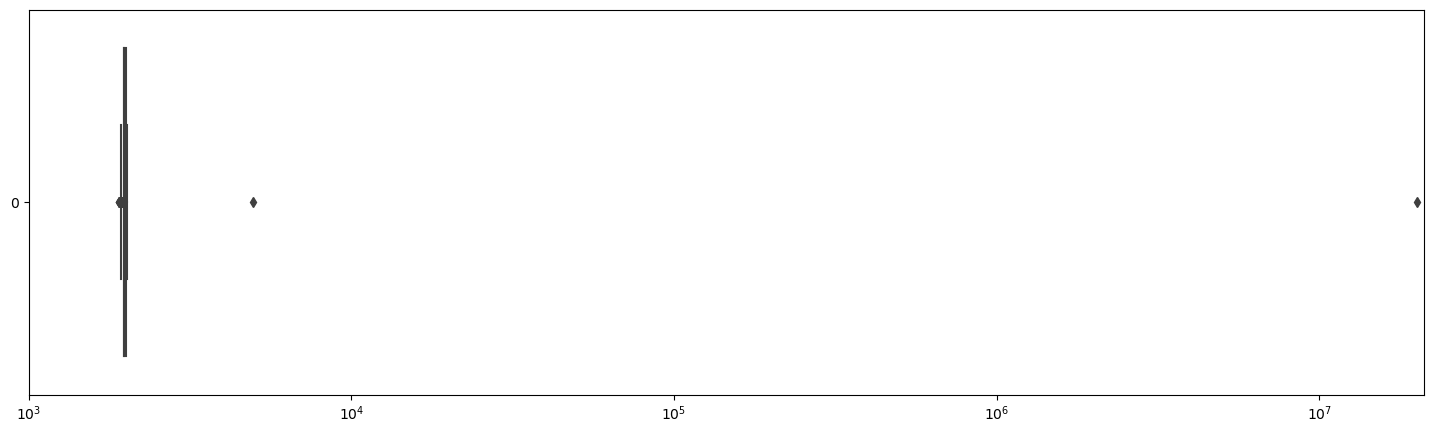

In [52]:
# Уточним для наглядности выбросы по году постройки
plt.figure(figsize=(18, 5))
sns.boxplot(data=X['HouseYear'], orient='h')
plt.xscale('symlog')
plt.xlim(left=1000)
plt.show()

Явно заметно наличие выбросов в количестве комнат, площадях, годах постройки дома.
Helthcare_2 - скорее относится к категориальным признакам.
Показатели местности Social, и Shops интерпретировать трудно.

Вероятно, в данных имеются не только ошибки, но и ОПЕЧАТКИ.

Для уточнения этого момента введем важный параметр для рынка недвижимости - ЦЕНУ КВАДРАТНОГО МЕТРА.

Возможно, это поможет в работе с выбросами. 

In [53]:
 X.loc[(X['Floor'] > X['HouseFloor'])]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7,74,2.0,80.312927,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156250
14,27,1.0,53.769096,52.408028,1.0,5,4.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,140647.562500
16,27,2.0,49.360649,31.993963,5.0,6,5.0,1983,0.051815,B,B,5,1227,0,NaN,0,0,B,117000.382812
21,27,2.0,64.711838,NaN,1.0,15,1.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,127200.023438
23,54,3.0,118.907608,NaN,0.0,2,0.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,571069.062500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9984,52,3.0,64.074974,47.633427,6.0,11,9.0,1983,0.371149,B,B,34,7065,1,750.0,2,5,B,226434.875000
9985,27,1.0,38.968338,NaN,1.0,10,1.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,95529.570312
9989,96,3.0,90.055229,47.860229,11.0,26,24.0,2005,0.041116,B,B,53,14892,4,NaN,1,4,B,441108.906250
9991,3,3.0,101.622795,51.628780,12.0,18,17.0,2000,0.265089,B,B,37,5288,0,1937.0,3,2,B,212883.500000


In [54]:
# Добавляем важный параметр для рынка недвижимости - ЦЕНУ КВАДРАТНОГО МЕТРА
X.insert(2,'SqMeterPrice', X.Price/X.Square)

In [55]:
# С помощью .describe еще раз посмотрим на данные
np.set_printoptions(precision = 2, suppress = True)
X.describe()

,DistrictId,Rooms,SqMeterPrice,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,3988.375977,56.315712,37.199596,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214139.218750
std,43.587592,0.839523,3755.437744,21.058718,86.241112,28.561113,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341,92872.304688
min,0.000000,0.000000,208.293457,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,20.000000,1.000000,2918.525391,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,36.000000,2.000000,3910.052246,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,75.000000,2.000000,4692.375977,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,209.000000,19.000000,230463.531250,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [56]:
# Создадим функцию для визуальной оценки признакa
def data_estimation (X, col):
    np.set_printoptions(suppress = True)
    print(X[col].value_counts() )
    plt.figure(figsize=(18, 5))
    sns.boxplot(data=X[col], orient='h')
#plt.xscale('symlog')
#plt.xlim(left=1800)
    plt.show()
    X.sort_values(by = col).tail(10)
#return df 

0    4214
1    2183
3    1670
2    1158
5     388
4     288
6      99
Name: Helthcare_2, dtype: int64


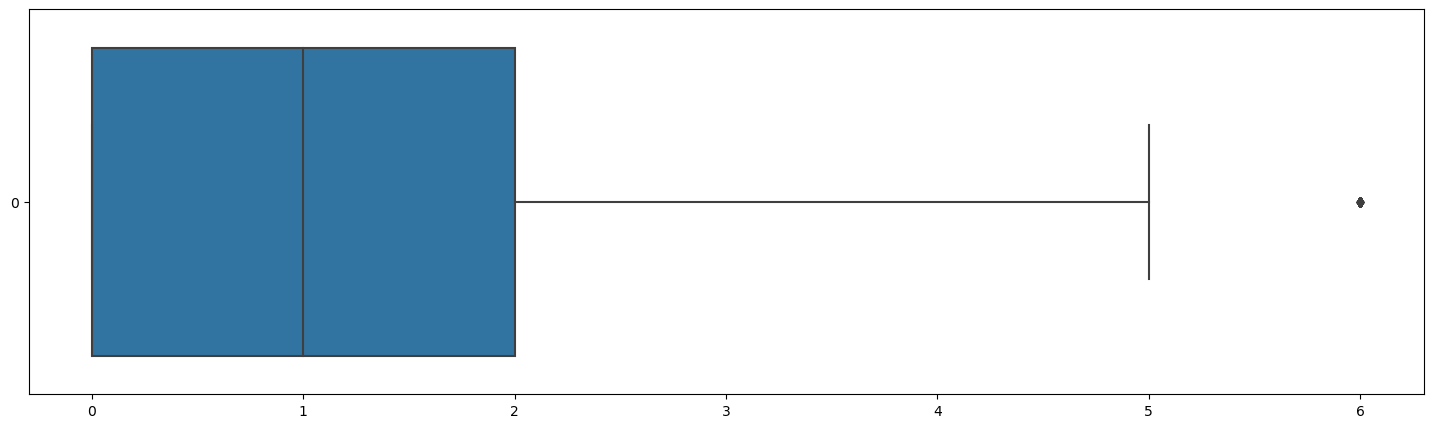

In [57]:
data_estimation(X, 'Helthcare_2')

In [58]:
X.sort_values(by = 'HouseYear').tail(10)

,DistrictId,Rooms,SqMeterPrice,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2493,53,1.0,4789.292969,35.672787,21.391266,8.0,4,24.0,2020,0.049637,B,B,34,7759,0,229.0,1,3,B,170847.421875
9674,53,2.0,4607.414551,57.126663,40.265099,10.0,11,24.0,2020,0.049637,B,B,34,7759,0,229.0,1,3,B,263206.218750
4053,45,2.0,5331.149414,82.880905,84.512718,1.0,19,22.0,2020,0.195781,B,B,23,5212,6,NaN,3,2,B,441850.468750
7459,53,1.0,4416.062012,38.004250,24.259308,8.0,4,24.0,2020,0.049637,B,B,34,7759,0,229.0,1,3,B,167829.125000
3357,62,1.0,2481.983643,55.911217,43.821381,10.0,6,17.0,2020,0.072158,B,B,2,629,1,NaN,0,0,A,138770.718750
7076,53,2.0,4345.723633,57.815311,37.287064,8.0,6,24.0,2020,0.049637,B,B,34,7759,0,229.0,1,3,B,251249.359375
5701,62,1.0,3078.778809,49.298504,51.135513,9.0,9,12.0,2020,0.072158,B,B,2,629,1,NaN,0,0,A,151779.187500
1499,120,2.0,6299.625000,85.087646,77.976326,10.0,7,10.0,2020,0.341072,B,B,27,5664,48,2300.0,3,11,B,536020.250000
4189,147,2.0,5425.734375,44.791836,28.360394,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.609375
1497,109,1.0,6818.302246,37.265072,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.531250


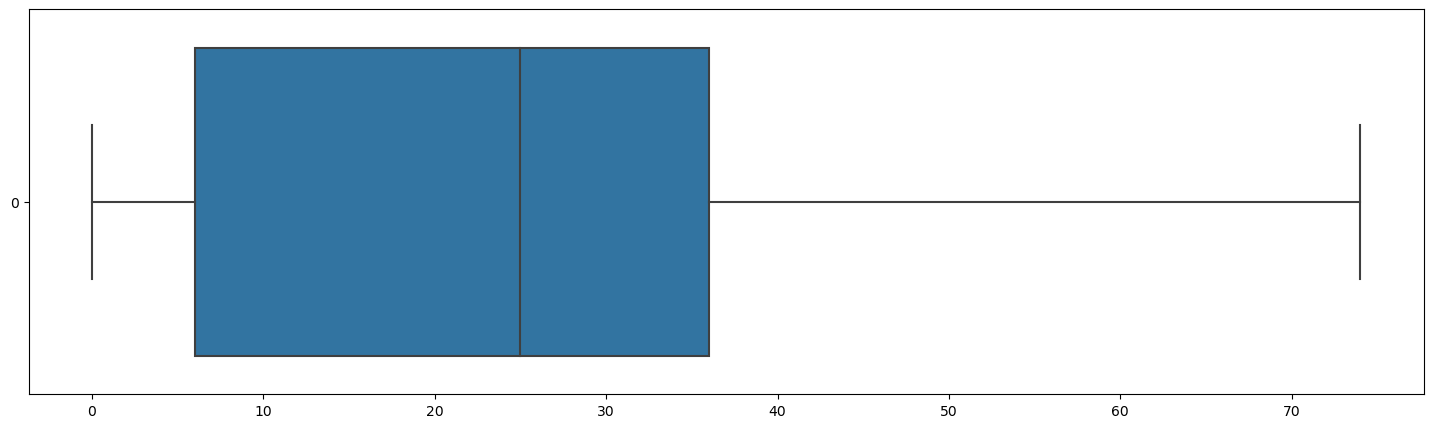

In [59]:
# Уточним для наглядности выбросы по цене квадратного метра
plt.figure(figsize=(18, 5))
sns.boxplot(data=X['Social_1'], orient='h')
#plt.xscale('symlog')
#plt.xlim(left=1800)
plt.show()

In [60]:

X.HouseYear.describe() #(by = 'HouseFloor').tail(30)
np.set_printoptions(precision = 2, suppress = True)
X.sort_values(by = 'Social_1').head(30) 
X.sort_values(by = 'LifeSquare')
#X['Rooms'].median()

,DistrictId,Rooms,SqMeterPrice,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
6609,0,1.0,2753.772461,38.178276,0.370619,0.0,19,17.0,2016,0.006076,B,B,30,5285,0,645.0,6,6,B,105134.289062
26,27,3.0,3153.547363,106.958870,0.641822,0.0,17,0.0,2018,0.072158,B,B,2,629,1,NaN,0,0,A,337299.875000
9602,6,2.0,2747.872559,63.591740,0.795539,10.0,17,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,174742.000000
4853,27,0.0,53253.582031,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.945312
2887,27,2.0,2433.192139,58.521099,1.049867,1.0,4,17.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A,142393.078125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,27,1.0,2451.466309,38.968338,NaN,1.0,10,1.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,95529.570312
9986,1,2.0,3082.311523,64.994247,NaN,1.0,9,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,200332.515625
9987,23,2.0,2081.937500,55.620090,NaN,0.0,2,4.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,115797.554688
9994,23,2.0,2641.264648,64.864197,NaN,1.0,17,17.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,171323.515625


In [61]:
X.loc[X['Square']<(X['KitchenSquare']+X['LifeSquare'])]

,DistrictId,Rooms,SqMeterPrice,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
3,58,2.0,3291.591797,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.234375
28,23,1.0,2241.666992,42.530045,43.967758,1.0,3,9.0,2014,0.034656,B,B,0,168,0,NaN,0,0,B,95338.195312
44,38,3.0,4178.641602,104.211395,106.340401,0.0,20,0.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.062500
48,23,1.0,2039.697510,47.080101,46.807991,12.0,3,9.0,1977,0.014073,B,B,2,475,0,NaN,0,0,B,96029.164062
52,1,2.0,3244.548340,61.400055,65.224602,0.0,17,22.0,2016,0.007122,B,B,1,264,0,NaN,0,1,B,199215.453125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9897,1,1.0,2542.745361,38.330353,38.010048,8.0,7,17.0,1991,0.025609,B,B,33,5261,0,240.0,3,1,B,97464.328125
9902,73,1.0,8660.954102,44.098766,44.267551,1.0,7,24.0,2014,0.042032,B,B,37,6856,84,1940.0,2,5,B,381937.406250
9910,27,4.0,2638.389404,200.334534,201.627365,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,NaN,1,4,B,528560.500000
9918,34,4.0,3959.389893,104.049133,99.788383,10.0,8,25.0,2018,0.069753,B,B,53,13670,4,NaN,1,11,B,411971.093750


In [62]:
X.loc[(X['KitchenSquare'] != 0) & (X['KitchenSquare'] <= 6)]

,DistrictId,Rooms,SqMeterPrice,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,35,2.0,3854.958740,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.937500
8,1,2.0,3551.351562,64.511436,NaN,1.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,229102.796875
10,28,2.0,4410.840332,46.304905,27.922585,6.0,8,9.0,1973,0.118537,B,B,30,6207,1,1183.0,1,0,B,204243.546875
12,13,2.0,4204.119141,54.522804,31.759752,1.0,8,12.0,1999,0.090799,B,B,74,19083,2,NaN,5,15,B,229220.375000
14,27,1.0,2615.769531,53.769096,52.408028,1.0,5,4.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,140647.562500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9986,1,2.0,3082.311523,64.994247,NaN,1.0,9,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,200332.515625
9990,1,3.0,2855.088623,57.373890,39.688446,5.0,2,5.0,1962,0.036270,B,B,6,1318,1,200.0,1,1,B,163807.546875
9994,23,2.0,2641.264648,64.864197,NaN,1.0,17,17.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,171323.515625
9995,32,2.0,3902.328125,50.401787,30.476204,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.312500


ОБЩИЕ НАБЛЮДЕНИЯ И ПРЕДЛОЖЕНИЯ ПО ПРЕДОБРАБОТКЕ ДАННЫХ

Вероятно, в данных имеются не только ошибки, но и ОПЕЧАТКИ.

Датасет явно заполнен не совсем достоверными данными. 
Сомнительно, что существуют жилые помещения площадью до 20 кв. м.

Не знаю американские нормативы, поэтому основываться будем на "здравый смысл"
Примем, что минимальная площадь квартиры (Square) не должна быть ниже 20 кв. м.
Объекты с площадью ниже 20 кв. м. УДАЛИМ.

Также визуальный анализ данных показал "странные" данные объектов, площадь которых больше 300 кв. м.
У нах аномально низкая цена за кв. м. Исключим из рассмотрения эти объекты.

Двухкомнатные квартиры редко бывают меньше 40 кв.м. Для таких квартир уменьшим количество комнат до одной.

В датафрейме много вариантов, где площадь кухни равна нулю. Это характерно для квартир-студий.
Однако квартира студия может быть только однокомнатной.
Поэтому в случае двух и более комнат нулевое значение площади кухни будем изменять.

Примем минимально возможную площадь кухни 5 кв. м. 
Исключения составляют варианты, где площадь кухни равна 0. Это могут быть квартиры-студии.
Примем максимально возможное отношение площади кухни к общей площади квартиры 0.3 (Кк = 0.3)
Кухни с площадью меньше минимально возможной в однокомнатных квартирах приравняем к минимально возможной.
В квартирах с Кк большим 0.3 площадь кухни приравняем к медианному значению площедей кухонь датасета.

При этом жилая площадь квартиры должна быть меньше общей площади хотя бы на 3 кв. м.
Предположим, что это минимальная площадь санузла и коридора. 

Графа с жилой площадью (LifeSquare)  содержит много пустых значений.
Примем коэффициент 0.65 максимального соотношения жилой площади к общей площади (Кж = 0.65). 
Примем минимальную площадь вспомогательных помещений равную 3 кв. м. (санузел и коридор).
Для жилой площади, если она меньше половины от площади, приравниваем ее к Кж.
Если жилая площадь больше, чем общая площадь за минусом кухни и туалета, то уменьшаем до возможного максимума (Кж).

Количество комнат в среднем составляет от 1 до 5. Есть несколько объектов с количеством комнат
от 6 до 19. У них очень маленький метраж для такого количества комнат и таких объектов всего 4.
Поэтому их просто удалим.

Примем нормативный коэффициент отношения жилой площади к общей равной 0.65. 
Для жилой площади, если она меньше половины общей площади, то приравниваем ее к нормативному коэффициенту
Если жилая площадь больше, чем общая площадь за минусом кухни и туалета, то уменьшаем до максимума
    
Минимальный этаж (Floor) расположения квартиры - нулевой, максимальный -42. 

По критерию "этажность дома" (HouseFloor) проходят три квартиры в домах общей этажностью 117 и 99 этажей соответственно.
В США вообще нет ЖИЛЫХ зданий с 117 и 99 этажами. Также для таких "небоскребов" характерна очень высокая стоимость квартир.
В представленном датасете она не сильно отличается от средней. Исключим такие данные.

Очень много строк (1210) с ситуацией, когда этажность дома НИЖЕ этажа расположения квартиры.
Примем в данном случае, что  этаж расположения квартиры равен этажности дома.

Год постройки дома в целом по датасету введен корректно. Исключения составляют только 2 объекта с годами больше 2022.
При этом у одного объекта год стоит как 20052011, что, вероятно, говорит о явной ошибке ввода даты вместо года. Учитывая американский формат ввода дат (месяц–день–год), предположим что это был 2011 г. Второй объект с годом "4968" просто исключим.

Признак "Ecology_1" непонятно что обозначает, но распределен особо без выбросов. 
Приведем выбросы к медианному значению.

Признаки 'Ecology_2' и 'Ecology_3' имеют значения только А, В. Будем их рассматривать как категориальные признаки.
То же относится и к признаку 'Shops_2'

Признак 'Social_1' непонятно что обозначает, но распределен без выбросов. 
Оставляем без изменений.

Признак "Social_2" непонятно что обозначает, но распределен особо без выбросов. 
Вероятно, это какие-то параметры инфраструктуры, поэтому их трогать пока не будем.

Признак "Social_3" непонятно что обозначает, но имеет довольно много выбросов. 
Вероятно, это какие-то параметры инфраструктуры, поэтому их трогать пока не будем.

Признак 'Healthcare_1' непонятен и содержит очень много пропущенных значений. 
Откажемся от учета этого признака в процессе анализа.

Признак "Shops_1" непонятно что обозначает, но распределен особо без выбросов. 
Вероятно, это какие-то параметры инфраструктуры, поэтому их трогать пока не будем.

Признак 'Helthcare_2' непонятно что обозначает, но распределен особо без выбросов. 
Вероятно, это какие-то параметры инфраструктуры, поэтому их трогать пока не будем.

Цена за кв.м тоже намекает об этом.
То же можно сказать о помещениях с площадью более 400 кв. м. и с низкой ценой за метр.

На основании вышеизложенных положений и доводов создадим подпрограмму коррекции данных
исходного датасета "data_correction"

In [63]:
data_train.sort_values(by = 'Floor')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4726,8231,11,1.0,31.309445,24.479166,5.0,1,5.0,1969,0.038693,B,B,28,6533,1,1015.0,2,5,B,134975.006573
9643,11272,129,2.0,44.564498,33.526766,5.0,1,5.0,1966,0.020741,B,B,24,5613,5,1340.0,2,5,B,186952.689225
2498,7713,11,2.0,47.033433,29.296514,5.0,1,5.0,1970,0.038693,B,B,28,6533,1,1015.0,2,5,B,178429.675260
7205,8187,99,2.0,50.018264,27.675253,6.0,1,9.0,1972,0.012339,B,B,35,5776,1,2078.0,2,4,B,177863.011266
2476,8474,30,1.0,49.277824,NaN,1.0,1,16.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,83754.899797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3330,3298,31,1.0,57.551691,21.551876,10.0,32,40.0,1977,0.151346,B,A,32,5889,10,830.0,4,1,B,393799.531732
339,11563,8,1.0,50.390862,41.642898,0.0,32,32.0,2008,0.092291,B,B,21,4346,2,165.0,1,2,B,97480.845791
8357,8016,31,1.0,59.519896,24.050533,10.0,33,40.0,1977,0.151346,B,A,32,5889,10,830.0,4,1,B,389554.063540
6755,8296,146,1.0,86.386754,71.904999,0.0,37,38.0,2012,0.236108,B,B,16,3893,27,NaN,3,10,B,269113.584248


In [64]:
# Создадим категориальные признаки из значений 'Ecology_2', 'Ecology_3' и 'Shops_2'
X['Ecology_2'] = X['Ecology_2'].map({'A':1, 'B':0})
X['Ecology_3'] = X['Ecology_3'].map({'A':1, 'B':0})
X['Shops_2'] = X['Shops_2'].map({'A':1, 'B':0})


In [65]:
# Откажемся от учета признака 'Healthcare_1' в процессе анализа
X = X.drop(columns='Healthcare_1') 

In [66]:
X

,DistrictId,Rooms,SqMeterPrice,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
0,35,2.0,3854.958740,47.981560,29.442751,6.0,7,9.0,1969,0.089040,0,0,33,7976,5,0,11,0,184966.937500
1,41,3.0,4567.491211,65.683640,40.049541,8.0,7,9.0,1978,0.000070,0,0,46,10309,1,1,16,0,300009.437500
2,53,2.0,4915.149414,44.947952,29.197611,0.0,8,12.0,1968,0.049637,0,0,34,7759,0,1,3,0,220925.906250
3,58,2.0,3291.591797,53.352982,52.731510,9.0,8,17.0,1977,0.437885,0,0,23,5735,3,0,5,0,175616.234375
4,99,1.0,3788.892578,39.649193,23.776169,7.0,11,12.0,1976,0.012339,0,0,35,5776,1,2,4,0,150226.531250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,32,2.0,3902.328125,50.401787,30.476204,5.0,6,5.0,1968,0.135650,0,0,46,7960,6,3,11,0,196684.312500
9996,18,1.0,4553.064941,41.521545,20.539215,9.0,13,13.0,2000,0.000000,0,0,30,5562,0,0,5,1,189050.296875
9997,27,1.0,3319.714355,47.939007,NaN,1.0,12,16.0,2015,0.072158,0,0,2,629,1,0,0,1,159143.812500
9998,75,2.0,4164.786133,43.602562,33.840149,8.0,1,5.0,1961,0.307467,0,1,30,5048,9,2,5,0,181595.343750


In [67]:
# ПОДПРОГРАММА ПРЕДОБРАБОТКИ ДАННЫХ
def data_correction(X):
    # Объекты с площадью ниже 20 кв. м. и выше 300 кв. м. УДАЛИМ
    X = X[(X.Square >= 20) & (X.Square < 300)]
           
     # Объекты с количеством комнат больше 5 УДАЛИМ
    X = X[(X.Rooms < 6)]
        
    # Для квартир площадью меньше 40 кв. м. уменьшим количество комнат до одной
    X.loc[(X['Square'] <= 40), 'Rooms'] = 1
    
    # Кухни с площадью меньше минимально возможной в однокомнатных квартирах приравняем к минимально возможной.
    # Исключения составляют варианты, где площадь кухни равна 0. Это могут быть квартиры-студии.
    
    X.loc[((X['KitchenSquare'] <= 5) & (X['Rooms'] == 1) & (X['KitchenSquare'] != 0) ) , 'KitchenSquare'] = 5
    
    # В квартирах с Кк большим 0.4 площадь кухни приравняем к медианному значению
    X.loc[((X['KitchenSquare'] < 5) | (X['KitchenSquare'] > 0.4 * X['Square'])), 'KitchenSquare'] = X['KitchenSquare'].median()
    
    # Для жилой площади, если она меньше половины от площади, приравниваем ее к Кж.
    X.loc[X['LifeSquare'] < (0.5 * X['Square']), 'LifeSquare'] = X['Square'] * 0.65
    X.loc[X['LifeSquare'].isnull(), 'LifeSquare'] = X['Square'] * 0.65
           
    # Если жилая площадь больше, чем общая площадь за минусом кухни и туалета, то уменьшаем до возможного максимума (Кж).       
    X.loc[(X['LifeSquare'] > (X['Square'] - X['KitchenSquare'] - 3)), 'LifeSquare'] = (X['Square'] - X['KitchenSquare'] - 3)  
    # df.loc[(df['LifeSquare'] < MIN_LIFE), 'LifeSquare'] = MIN_LIFE
    
    # Объекты на этажах выше 99 УДАЛИМ
    X = X[(X.Floor < 99)]
            
    # Если этажность дома НИЖЕ этажа расположения квартиры принимаем, что этажность дома равна этажу расположения квартиры 
    X.loc[(X['Floor'] > X['HouseFloor']), 'Floor'] = X['Floor']
    
    # Год постройки дома в целом по датасету введен корректно. Исключения составляют только 2 объекта с годами больше 2022. 
    # При этом у одного объекта год стоит как 20052011, что, вероятно, говорит о явной ошибке ввода даты вместо года. 
    #Учитывая американский формат ввода дат (месяц–день–год), предположим что это был 2011 г. 
    # Второй объект с годом "4968" просто исключим.
    X.loc[(X['HouseYear'] == 20052011), 'HouseYear'] = 2011
    X = X[X.HouseYear <= 2022]
        
    return X

In [68]:
#data_correction(X)
X = data_correction(X)
X.sort_values('Floor')

,DistrictId,Rooms,SqMeterPrice,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
4724,7,2.0,3534.152100,47.836559,29.006094,5.0,1,14.0,1971,0.130618,0,0,39,10418,9,1,9,0,169061.671875
2145,23,2.0,1688.288208,54.364914,35.337193,6.0,1,0.0,1977,0.034656,0,0,0,168,0,0,0,0,91783.640625
6435,47,1.0,4421.475098,38.082912,24.890329,8.0,1,14.0,2002,0.000070,0,0,46,10309,1,1,16,0,168382.656250
9641,24,2.0,4124.953613,46.307499,32.281948,6.0,1,5.0,1962,0.111627,0,0,50,12238,8,2,3,0,191016.281250
3191,111,1.0,4772.978516,31.649582,21.481131,5.0,1,9.0,1963,0.136330,0,0,30,6141,10,3,6,0,151062.781250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,8,1.0,1934.494507,50.390862,41.390862,6.0,32,32.0,2008,0.092291,0,0,21,4346,2,1,2,0,97480.843750
3330,31,1.0,6842.536133,57.551693,37.408600,10.0,32,40.0,1977,0.151346,0,1,32,5889,10,4,1,0,393799.531250
8357,31,1.0,6544.938477,59.519897,38.687931,10.0,33,40.0,1977,0.151346,0,1,32,5889,10,4,1,0,389554.062500
6755,146,1.0,3115.218262,86.386757,71.904999,6.0,37,38.0,2012,0.236108,0,0,16,3893,27,3,10,0,269113.593750


In [69]:
# Проверяем отсутствие пропусков
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9971 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   DistrictId     9971 non-null   int16   
 1   Rooms          9971 non-null   float32 
 2   SqMeterPrice   9971 non-null   float32 
 3   Square         9971 non-null   float32 
 4   LifeSquare     9971 non-null   float32 
 5   KitchenSquare  9971 non-null   float32 
 6   Floor          9971 non-null   int8    
 7   HouseFloor     9971 non-null   float32 
 8   HouseYear      9971 non-null   int32   
 9   Ecology_1      9971 non-null   float32 
 10  Ecology_2      9971 non-null   category
 11  Ecology_3      9971 non-null   category
 12  Social_1       9971 non-null   int8    
 13  Social_2       9971 non-null   int16   
 14  Social_3       9971 non-null   int16   
 15  Helthcare_2    9971 non-null   int8    
 16  Shops_1        9971 non-null   int8    
 17  Shops_2        9971 non-null   ca

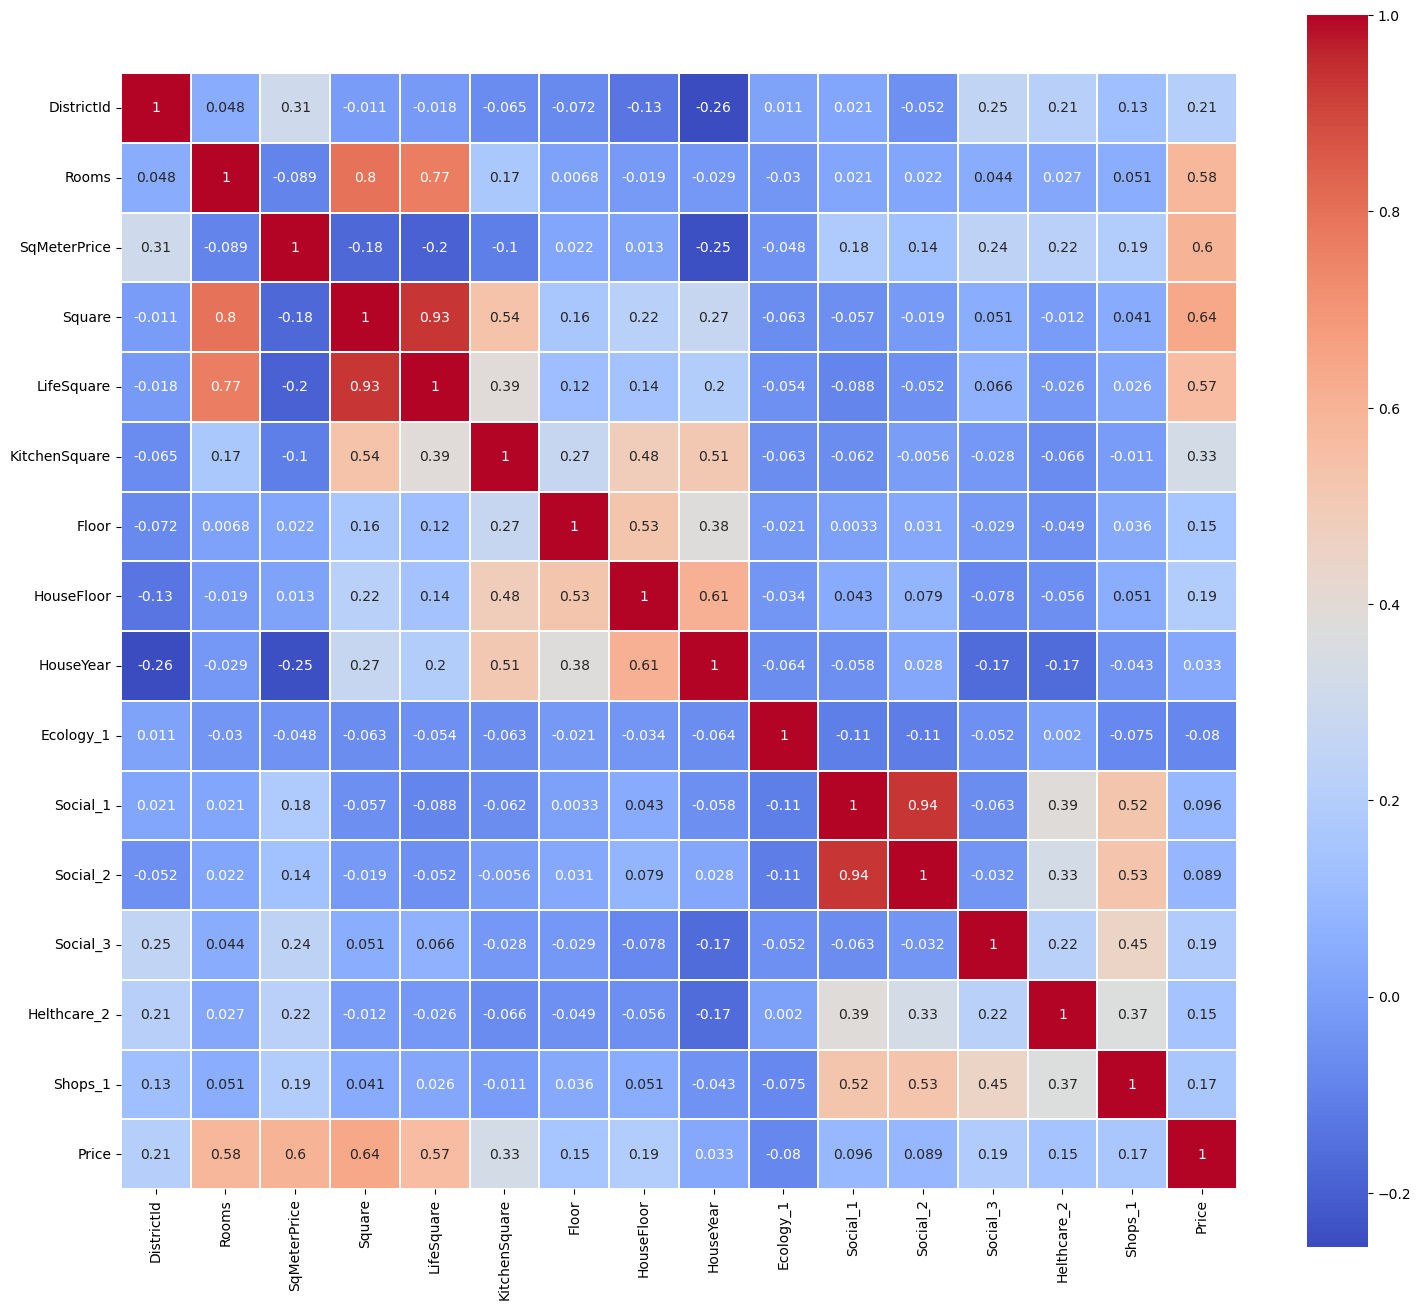

In [35]:
# Посмотрим на корреляцию признаков в датасете
X_corr=X.corr()
plt.figure(figsize=(18,16))
sns.heatmap(X_corr, annot=True, linewidths=0.3, cmap='coolwarm', square=True)
plt.show()

<AxesSubplot:>

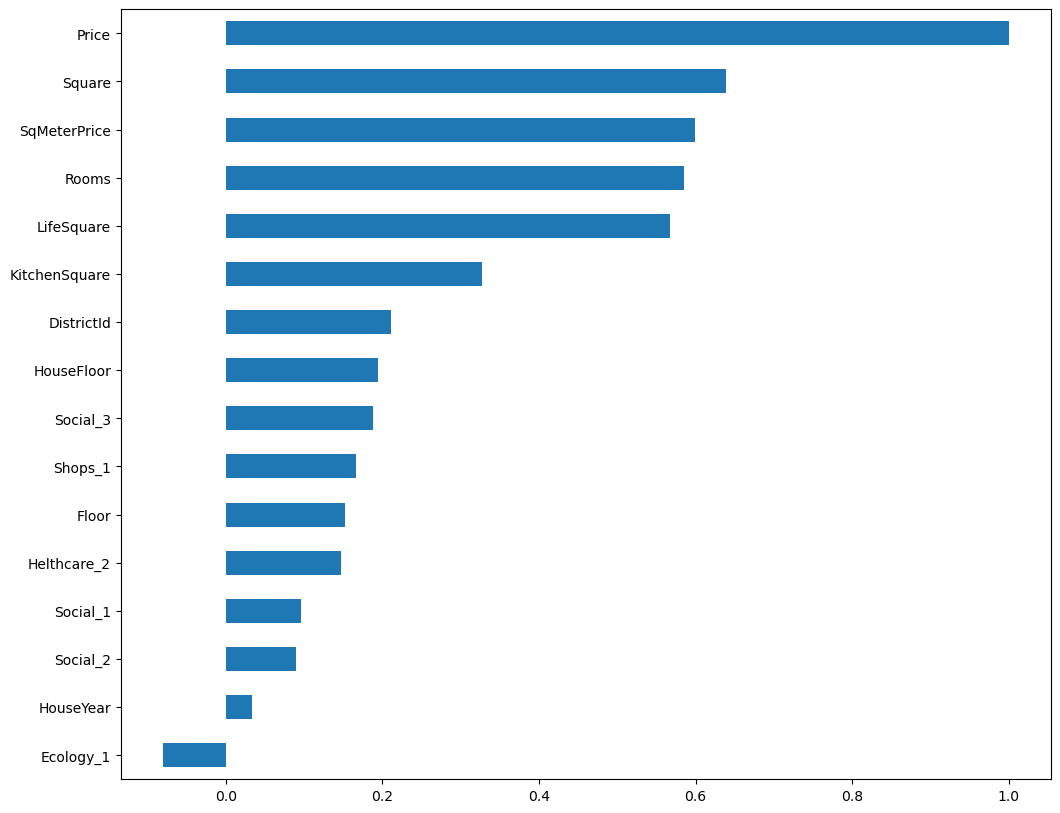

In [36]:
# Для большей наглядности построим диаграмму корреляции признаков в датасете
plt.figure(figsize = (12,10))
X.corr()['Price'].sort_values(ascending=True).plot(kind='barh')

In [62]:
# Для оценки средней цены квадратного метра определим медианное значение площадей квартир
# и посмотрим распределение цен в этой окрестности
X.LifeSquare.median()

34.170135498046875

In [70]:
X.loc[X['LifeSquare'] < (0.5 * X['Square']), 'LifeSquare'] = X['Square'] * 0.65
X.loc[X['LifeSquare'].isnull(), 'LifeSquare'] = X['Square'] * 0.65
X

,DistrictId,Rooms,SqMeterPrice,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
0,35,2.0,3854.958740,47.981560,29.442751,6.0,7,9.0,1969,0.089040,0,0,33,7976,5,0,11,0,184966.937500
1,41,3.0,4567.491211,65.683640,40.049541,8.0,7,9.0,1978,0.000070,0,0,46,10309,1,1,16,0,300009.437500
2,53,2.0,4915.149414,44.947952,29.197611,0.0,8,12.0,1968,0.049637,0,0,34,7759,0,1,3,0,220925.906250
3,58,2.0,3291.591797,53.352982,52.731510,9.0,8,17.0,1977,0.437885,0,0,23,5735,3,0,5,0,175616.234375
4,99,1.0,3788.892578,39.649193,23.776169,7.0,11,12.0,1976,0.012339,0,0,35,5776,1,2,4,0,150226.531250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,32,2.0,3902.328125,50.401787,30.476204,5.0,6,5.0,1968,0.135650,0,0,46,7960,6,3,11,0,196684.312500
9996,18,1.0,4553.064941,41.521545,26.989004,9.0,13,13.0,2000,0.000000,0,0,30,5562,0,0,5,1,189050.296875
9997,27,1.0,3319.714355,47.939007,31.160353,1.0,12,16.0,2015,0.072158,0,0,2,629,1,0,0,1,159143.812500
9998,75,2.0,4164.786133,43.602562,33.840149,8.0,1,5.0,1961,0.307467,0,1,30,5048,9,2,5,0,181595.343750


In [67]:
X.sort_values(by = 'KitchenSquare')

,DistrictId,Rooms,SqMeterPrice,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
8227,1,1.0,3190.932617,42.852921,40.924603,0.0,9,17.0,1977,0.007122,0,0,1,264,0,0,1,0,136740.781250
3302,23,2.0,1998.347534,51.767887,48.262543,0.0,3,9.0,2015,0.034656,0,0,0,168,0,0,0,0,103450.226562
9098,27,2.0,2296.893311,59.751888,38.838726,0.0,8,12.0,1977,0.011654,0,0,4,915,0,0,0,0,137243.718750
760,23,2.0,2680.073242,62.162125,60.956978,0.0,7,25.0,1977,0.075779,0,0,6,1437,3,0,2,0,166599.046875
8192,1,2.0,3213.179443,64.432175,64.312027,0.0,10,20.0,1977,0.007122,0,0,1,264,0,0,1,0,207032.140625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2969,62,3.0,2747.609619,114.734474,112.589081,112.0,3,3.0,2015,0.072158,0,0,2,629,1,0,0,1,315245.531250
4651,58,3.0,2544.256348,116.405693,113.109650,112.0,3,3.0,2016,0.437885,0,0,23,5735,3,0,5,0,296165.937500
9895,27,3.0,1897.388916,123.430069,125.806984,123.0,5,10.0,2015,0.017647,0,0,2,469,0,0,0,0,234194.843750
8584,81,1.0,3269.840820,32.276665,19.278395,1970.0,6,1.0,1977,0.006076,0,0,30,5285,0,6,6,0,105539.554688


In [24]:
X.LifeSquare.max()

7480.59228515625

In [25]:
X.LifeSquare.min()

0.37061941623687744

In [26]:
X[X.LifeSquare > 220]

,DistrictId,Rooms,SqMeterPrice,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
590,23,2.0,2926.328125,48.449875,263.542023,5.0,6,5.0,1972,0.075779,B,B,6,1437,3,NaN,0,2,B,141780.234375
1982,86,5.0,1651.633057,275.645294,233.949310,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.875000
4328,27,3.0,2660.616211,81.694420,7480.592285,1.0,9,17.0,2016,0.017647,B,B,2,469,0,NaN,0,0,B,217357.500000
4690,102,1.0,220.969391,409.425171,410.639740,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.429688
6977,30,2.0,208.293457,641.065186,638.163208,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.687500
8437,85,3.0,5050.687500,78.059334,461.463623,10.0,12,16.0,1998,0.037178,B,B,52,11217,1,2300.0,1,7,B,394253.312500


In [27]:
X[X.LifeSquare < 10]

,DistrictId,Rooms,SqMeterPrice,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
26,27,3.0,3153.547363,106.958870,0.641822,0.0,17,0.0,2018,0.072158,B,B,2,629,1,NaN,0,0,A,337299.875000
95,34,2.0,4672.121582,61.334969,4.091945,1.0,26,1.0,2014,0.069753,B,B,53,13670,4,NaN,1,11,B,286564.437500
134,6,2.0,2759.340820,65.496674,5.589324,1.0,5,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,180727.640625
158,27,3.0,3359.953369,51.991066,4.896202,1.0,22,25.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,174687.562500
160,6,1.0,2911.197021,66.419838,3.987101,1.0,2,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,193361.234375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9756,27,2.0,2422.507568,58.943039,3.319486,1.0,11,17.0,2017,0.011654,B,B,4,915,0,NaN,0,0,B,142789.953125
9813,62,1.0,1836.853027,122.438148,5.751401,1.0,2,3.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,224900.890625
9828,24,3.0,4807.656250,127.141144,4.811405,1.0,3,1.0,2017,0.111627,B,B,50,12238,8,1970.0,2,3,B,611250.937500
9888,6,1.0,3852.121094,41.314774,5.005477,1.0,9,17.0,2016,0.243205,B,B,5,1564,0,540.0,0,0,B,159149.515625


C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='LifeSquare'>

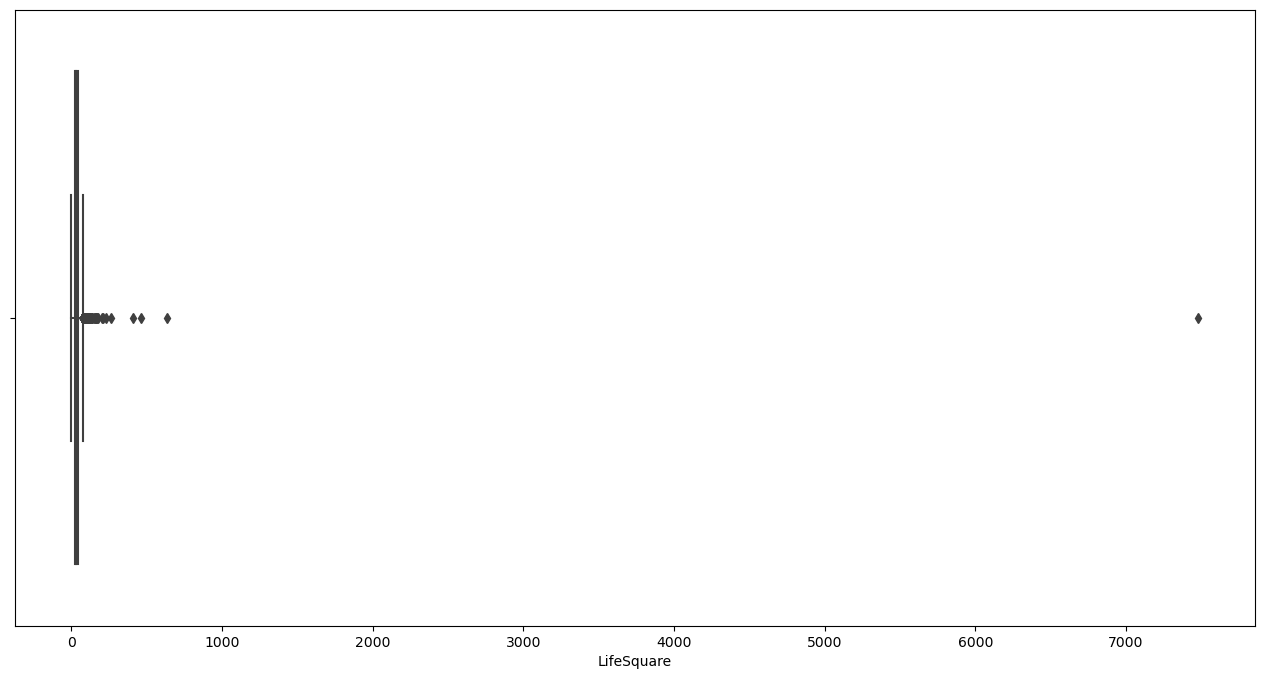

In [28]:
plt.figure(figsize = (16, 8))
sns.boxplot(X.LifeSquare)

#plt.hist(X.LifeSquare, bins=50) 

#axis([0, 1,0, 10000])

In [29]:
X = X[X['LifeSquare'] < 1000]
X

,DistrictId,Rooms,SqMeterPrice,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,35,2.0,3854.958740,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.937500
1,41,3.0,4567.491211,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.437500
2,53,2.0,4915.149414,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.906250
3,58,2.0,3291.591797,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.234375
4,99,1.0,3788.892578,39.649193,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,13,3.0,4349.235352,80.631332,48.899082,10.0,11,14.0,1999,0.090799,B,B,74,19083,2,NaN,5,15,B,350684.625000
9995,32,2.0,3902.328125,50.401787,30.476204,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.312500
9996,18,1.0,4553.064941,41.521545,20.539215,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.296875
9998,75,2.0,4164.786133,43.602562,33.840149,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.343750
